In [2]:
!pip install texttable
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gzip
from PIL import Image
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import requests
import pandas as pd
from texttable import Texttable
from IPython.display import clear_output

In [3]:
class Visualizer():
    '''
    Class encapsulates the visualization method that plots the loss and required evaluation metrics against the epoch number.
    Attributes:
        losses: List of calculated scaler losses occured at each epoch.
        accuracy: List of calculated scaler accuracies occured at each epoch.
        f1score: List of calculated scaler f1scores occured at each epoch.
        precision: List of calculated scaler precisions occured at each epoch.
        recall: List of calculated scaler recalls occured at each epoch. 
        mode: String represents the metric required to be visualized.
        metric_mode: List of metric values according to the passed mode.
    '''
    # This function is called when the training begins
    def __init__(self, mode= 'all'):
        '''
        Initializes the class attributes.
        '''
        # Initialize the lists for holding the logs, losses and metrics
        self.losses = []
        self.accuracy = []
        self.f1score = []
        self.precision = []
        self.recall = []
        self.mode = mode
        self.metric_mode = []


    # This function is called at the end of each epoch
    def on_epoch_end(self, logs={}):
        """
        Calculates and plots Precision, Recall, F1 score
        Arguments:
            logs: Dictionary consists of the metric mode name as dictionary key and its values as dictionary values. The dictionary also have special entry for the loss with the string "loss" as dictionary entry key and the value of the loss at the given epoch as dictionary entry value.
        """
        # Extract from the log
        if self.mode == "all":
            accuracy = logs['accuracy']
            f1score =logs['f1']
            recall =logs['recall']
            precision =logs['precision']
            self.accuracy.append(accuracy)
            self.f1score.append(f1score)
            self.precision.append(precision)
            self.recall.append(recall)
        else:
            metric_mode = logs[self.mode]
            self.metric_mode.append(metric_mode)
        loss=logs['loss']
        self.losses.append(loss)
    
        # Clear the previous plot
        if logs['type']=="train":
          clear_output(wait=True)
        N = np.arange(1, len(self.losses)+1)
        
        # You can chose the style of your preference

        plt.style.use("seaborn")
        plt.figure(figsize=(20,4))
        # Plot train loss, train acc, val loss and val acc against epochs passed
        plt.title("{} Loss over epoch number {}".format(logs['type'],len(self.losses)))
        plt.ylabel("Loss")
        plt.plot(N, self.losses,c='blue', marker='o', linestyle='solid')


        if (self.mode == "all"):
            fig, ax = plt.subplots(1,4, figsize=(20,4))
            ax = ax.ravel()
            ax[0].plot(N, self.precision, label = "Precision", c = 'red', marker='o', linestyle='solid')
            ax[1].plot(N, self.recall, label = "Recall", c = 'red', marker='o', linestyle='solid')
            ax[2].plot(N, self.f1score, label = "F1 score", c = 'red', marker='o', linestyle='solid')
            ax[3].plot(N, self.accuracy, label = "Precision", c = 'red', marker='o', linestyle='solid')
            ax[0].set_title("Precision at Epoch No. {}".format(len(self.losses)))
            ax[1].set_title("Recall at Epoch No. {}".format(len(self.losses)))
            ax[2].set_title("F1-score at Epoch No. {}".format(len(self.losses)))
            ax[3].set_title("Accuracy at Epoch No. {}".format(len(self.losses)))
            ax[0].set_xlabel("Epoch #")
            ax[1].set_xlabel("Epoch #")
            ax[2].set_xlabel("Epoch #")
            ax[3].set_xlabel("Epoch #")
            ax[0].set_ylabel("Precision")
            ax[1].set_ylabel("Recall")
            ax[2].set_ylabel("F1 score")
            ax[3].set_ylabel("Accuracy")
            ax[0].set_ylim(0,1)
            ax[1].set_ylim(0,1)
            ax[2].set_ylim(0,1)
            ax[3].set_ylim(0,1)
        else:
            fig, ax = plt.subplots(1,1, figsize=(12,4))
            ax.plot(N, self.metric_mode, label = self.mode, c = 'red', marker='o', linestyle='solid')
            ax.set_title("{} at Epoch No. {}".format(self.mode, len(self.losses)))
            ax.set_xlabel("Epoch #")
            ax.set_ylabel(self.mode)
            ax.set_ylim(0,1)
        plt.show()

In [4]:
'''
First: Some Utilities
The following three functions are used to dowload the dataset if it is not available in the path specified when instantiating an object of the dataset class.
We uploaded the dataset files to google drive to be easily accessed from remote computers.
These fuctions were taken from a stackoverflow answer.
Generally, one call of download_file_from_google_drive downloads one file.
The following three functions is not part of the framework so they will not be documented.  
'''
def download_file_from_google_drive(id, destination, status):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id': id }, stream = True)
    token = get_confirm_token(response)

    print(f'Downloading {status}...')
    if token:
        params = { 'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    
    print("Finished Successfully.")

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

class Dataset():
    '''
    Abstract class represents a dataset. Generally, any dataset inherits from this class have to have path to the root file which contains all its files.
    Methods:
        __getItem__() simply returns an item of the dataset. An item is the combination of an image and its corresponding label. The item maybe training, validation or test item.
        length() gets the length of a certain (training, validation or test) subset of the dataset.
        load() returns the training, validation and test sets splitted in arrays. 
    '''
    def __init__(self, rootFilePath):
        self.rootFilePath = rootFilePath
    def __getItem__(self, index):
        raise NotImplementedError
    def length(self):
        raise NotImplementedError
    def load(self):
        raise NotImplementedError

class Mnist(Dataset):
    '''
    Class representing the Mnist "iterable" dataset. 
    The class stores the google drive file Id of each of the mnist dataset files. These Ids are essential to download the files if they are not available in the specified root path.
    It also stores the names of gzip files that contains the training and test sets. 
    "Set" here refers to the the combination of an image and a label.
    The class stores the splitted training, validation and test sets in numpy arrays.
    The class finally stores __index and iterate_on_attr attributes which used in iterating on the datasets
    '''
    trainingImagesId = '1AFEVsHzlT8H_avcouMl694PwFEyNzirr'
    trainingLabelsId = '1rhFLe9WbSK8bnbXnglX9b4AgOB7tfPsS'
    testImagesId = '1duWaOCrpieH9O9GKMR-xIUSzRJNFyVOQ'
    testLabelsId = '1IEhyDpgPgKv-S6Sx7AIufUmjmH97Om6w'
    def __init__(self, rootFilePath, seed = 42, split_ratio = 0.2): 
        '''
        The __init__ function is called whenever the class is instantiated. 
        Arguments: 
            rootFilePath: String represents the path to the root folder in which the dataset files are stored. If the files were not found, the object notifies the user that it will procceed downloading the dataset files online from the internet.
            seed: Integer represents the seed of the random process of numpy. numpy.random is used to randomly shuffle the training set. The user can set the seed of the random shuffling to match a constant seed he/she wants across the code.
            split_ratio: float represents the ratio by which the mnist training files are split into validation and training sets. The split_ratio equals the required portion of validation set of the total given mnist training set. If the user needs to do the split manually, the he/she can set the split_ratio to zero and the object stores only training and test sets.
        '''
        super(Mnist, self).__init__(rootFilePath)
        self.trainingImagesName = os.path.join(self.rootFilePath, 'train-images-idx3-ubyte.gz')
        self.trainingLabelsName = os.path.join(self.rootFilePath, 'train-labels-idx1-ubyte.gz')
        self.testImagesName = os.path.join(self.rootFilePath, 't10k-images-idx3-ubyte.gz')
        self.testLabelsName = os.path.join(self.rootFilePath, 't10k-labels-idx1-ubyte.gz')
        if not os.path.exists(self.trainingImagesName)\
           or not os.path.exists(self.trainingLabelsName)\
           or not os.path.exists(self.testImagesName)\
           or not os.path.exists(self.testLabelsName):
           response = input('Some files are missing. Do you want to download the dataset online? [y/n]')
           if response.lower() == "n":
               raise SystemExit()
           else:
               download_file_from_google_drive(self.trainingImagesId, self.trainingImagesName, "Training Images")
               download_file_from_google_drive(self.trainingLabelsId, self.trainingLabelsName, "Training Labels")
               download_file_from_google_drive(self.testImagesId, self.testImagesName, "Test Images")
               download_file_from_google_drive(self.testLabelsId, self.testLabelsName, "Test Labels")
        training_and_validation_images = self.get_images(self.trainingImagesName).copy()
        training_and_validation_labels = self.get_labels(self.trainingLabelsName).copy()
        np.random.seed(seed)
        state = np.random.get_state()
        np.random.shuffle(training_and_validation_images)
        np.random.set_state(state)
        np.random.shuffle(training_and_validation_labels)
        training_end_index = int((1 - split_ratio)*len(training_and_validation_images))
        self.training_images = training_and_validation_images[:training_end_index]
        self.training_labels = training_and_validation_labels[:training_end_index]
        self.validation_images = training_and_validation_images[training_end_index:]
        self.validation_labels = training_and_validation_labels[training_end_index:]
        self.test_images = self.get_images(self.testImagesName)
        self.test_labels = self.get_labels(self.testLabelsName)
        self.__index = 0
        self.iterate_on_attr = "training"
    def iterate_on(self, iterate_on):
        '''
        Specifies which set (training, validation or test) is to be iterated on.
        Arguments:
            iterate_on: string indicates the set to be iterated on.
        '''
        self.iterate_on_attr = iterate_on
    def load(self):
        '''
        Returns:
            training_images: array of shape (<num_of_training_imgs>, 28, 28) contains training images, each of 28x28 shape.
            training_labels: array of shape (<num_of_training_imgs>, 1) contains the labels corresponding to the training images.
            validation_images: array of shape (<num_of_validation_imgs>, 28, 28) contains validation images, each of 28x28 shape.
            validation_labels: array of shape (<num_of_validation_imgs>, 1) contains the labels corresponding to the validation images.
            test_images: array of shape (10000, 28, 28) contains test images, each of 28x28 shape.
            test_labels: array of shape (10000, 1) contains the labels corresponding to the test images.
        '''
        return self.training_images, self.training_labels, self.validation_images, self.validation_labels, self.test_images, self.test_labels
    def __getItem__(self, index, from_set = "training", all = False):
        '''
        Gets an item of a specific set at a specific index.
        Arguments:
            index: Integer represents the index of the specified set from which an item (image + label) is gotten.
            from_set: String represents the set from which the item (image + label) is gotten.
            all: Boolean that if set true, the function returns a specific item the is combined of one training image, one training label, one validation image, one validation label, one test image and one test label.
        Returns:
            PILImage: Python Imaging Library (PIL) image from an array at the given index from the given set.
            intLabels: Integer represents the label that corresponds to the returned PIL Image.
        '''
        from_set = from_set.lower()
        if from_set == "training" and not all:
            PILImage = Image.fromarray(self.training_images[index], mode= 'L') 
            # mode = 'L' indicates 8 bits black and white images
            intLabels = self.training_labels[index].item()
        elif from_set == "test" and not all:
            PILImage = Image.fromarray(self.test_images[index], mode= 'L') 
            intLabels = self.test_labels[index].item()
        elif from_set == "validation" and not all:
            PILImage = Image.fromarray(self.validation_images[index], mode= 'L') 
            intLabels = self.validation_labels[index].item()
        elif all:
            return Image.fromarray(self.training_images[index], mode= 'L'),\
            self.training_labels[index].item(),\
            Image.fromarray(self.validation_images[index], mode= 'L'),\
            self.validation_labels[index].item(),\
            Image.fromarray(self.test_images[index], mode= 'L'),\
            self.test_labels[index].item()
        return PILImage, intLabels
    def length(self, set = "training"):
        '''
        Gets the length of a specified set.
        Arguments:
            set: String represents the set which its length is required.
        Returns:
            The length of the specified set.
        '''
        set = set.lower()
        if set == "training":
            return len(self.training_images)
        elif set == "test":
            return len(self.test_images)
        elif set == "validation":
            return len(self.validation_images)
    def __iter__(self):
        '''
        The function required to make the dataset iterable.
        '''
        self.__index = 0
        return self 
    def __next__(self):
        '''
        The function that gets the next item from the iterable.
        Returns:
            The next item from the set specified by the iterate_on_attr.
        '''
        if self.__index < self.length(self.iterate_on_attr):
            next = self.__getItem__(self.__index, from_set = self.iterate_on_attr)
            self.__index += 1
            return next
        else:
            raise StopIteration
    def generate(self, from_set = "training", index= 0):
        '''
        Generator function that continously generates items from the specifed set starting from a given index.
        Arguments:
            from_set: String indicates the set that items are being generated from.
            index: Integer indicates the place from which the function starts the generation.
        Yields (Actually it returns continously):
            An item of the given set at the given item. 
        '''
        internal_index = index
        while True:
            if internal_index < self.length(from_set):
                yield self.__getItem__(internal_index, from_set = from_set)
                internal_index += 1
            else: 
                break
    def showSample(self, from_set = "training", startFrom= 0, coloumn= 5, row= 5, figsize= (10, 10)):
        '''
        Plots a sample of images and labels from a given set.
        Arguments:
            from_set: String indicates the set that the shown sample is from.
            startFrom: Integer indicates the index from which the function will visualize a set of images.
            coloumn: Integer indicates number of coloumns of images is required. 
            row: Integer indicates number of rows of images is required. 
            figsize: Tuple of two integers indicates the area of an image (passed to matplotlib.pyplot.plot).
        '''
        from_set = from_set.lower()
        fig = plt.figure(figsize= figsize)
        mnist_iter = self.generate(from_set, startFrom)
        for i in range(1, coloumn*row+1):
            img, label = next(mnist_iter)
            ax = fig.add_subplot(row, coloumn, i)
            ax.title.set_text('Label: ' + str(label))
            plt.imshow(img)
            plt.axis('off')
        plt.show()
    def read_idx_file(self, f, num_bytes= 4, endianness= 'big'):
        '''
        Reads specific number of bytes from a given .idx file (used to store the mnist dataset) taking endianness into consideration.
        Arguments:
            f: .idx (index) file.
            num_bytes: Integer number of bytes to be read from the given .idx file.
            endianness: String specifies the endianness of the given file. (C.O. Lesson: Endianness-> The way computer stores the bytes in memory. Big endian processor stores the most significant byte in the highest memory address and vice versa)
        Returns:
            Series of integers from the read bytes.
        '''
        return int.from_bytes(f.read(num_bytes), endianness)
    def get_images(self, compressedFilePath):
        '''
        Transforms the raw bytes read from the idx file into images.
        Arguments:
            compressedFilePath: String represents the path of the compressed gzip file.
        Returns:
            images: Array of integers ranging from 0 to 255 representing the images in the given file.
        '''
        with gzip.open(compressedFilePath, 'r') as f:
            magicNumber = self.read_idx_file(f) # Used to make sure that the file is read correctly.
            try:
                assert magicNumber == 2051 
            except:
                print('Error getting images (Magic number error)')
                raise SystemExit()
            num_images = self.read_idx_file(f) 
            num_rows = self.read_idx_file(f)
            num_coloumns = self.read_idx_file(f)
            rest_values = f.read()
            images = np.frombuffer(rest_values, dtype = np.uint8).reshape((num_images, num_rows, num_coloumns))
            return images
    def get_labels(self, compressedFilePath):
        '''
        Transforms the raw bytes read from the idx file into labels.
        Arguments:
            compressedFilePath: String represents the path of the compressed gzip file.
        Returns:
            labels: Array of integers ranging from 0 to 9 representing the labels corresponding to the images in the given file.
        '''
        with gzip.open(compressedFilePath, 'r') as f:
            magicNumber = self.read_idx_file(f) # Used to make sure that the file is read correctly.
            try:
                assert magicNumber == 2049 
            except:
                print('Error in training labels (Magic number error)')
                raise SystemExit()
            num_labels = self.read_idx_file(f)
            rest_values = f.read()
            labels = np.frombuffer(rest_values, dtype = np.uint8).reshape((num_labels, 1))
            return labels

In [5]:
class Storage():
    def __init__(self):
        pass
    def save_model(self, model, file_name, save_path):
        '''
        This method saves the passed model into the passed path with the passed name.
        Attributes:
            model: Object of type model representing the current state of the model you want to save.
            file_name: Beautiful name of your choice for the file to be pickled. If you want to save many models, then every model MUST have a unique name. If an already exists file name passed, then the saved old model will be lost.
            save_path: The file path you want to save your model in. 
        '''
        file_path = os.path.join(save_path, file_name + ".pickle")
        if os.path.exists(file_path):
            print("WARNING: There is another model with the same name. The old one will be lost.")
        pickled_file = open(file_path, "wb")
        pickle.dump(model, pickled_file)
        pickled_file.close()
    def load_model(self, file_name, load_path):
        '''
        This method loads a model from the passed path with the passed name.
        Attributes:
            file_name: Name of the file you saved your model in. If there is not a .pickle file with the same name, the methods returns None.
            save_path: The file path you want to load your model from.
        '''
        file_path = os.path.join(load_path, file_name + ".pickle")
        if not os.path.exists(file_path):
            print("File not found")
            return None
        unpickled_file = open(file_path, "rb")
        model = pickle.load(unpickled_file)
        unpickled_file.close()
        return model

In [6]:
class Evaluation_metrics():
  '''
  Class encapsulates the following training process evaluation metrics: accuracy, precision, recall and F1score.
  Attributes:
    evaluation_type: String represents the metric of evaluation.
    numberOfClasses: Integer represents the number of the output classes.
    plot: if one, the confusion matrix is visually plotted.
  '''
  def __init__(self, evaluation_type="accuracy", numberOfClasses=9, plot=0):
    '''
    Sets the class attributes to the passed attributes.
    '''
    self.evaluation_type=evaluation_type
    self.numberOfClasses=numberOfClasses
    self.plot=plot

  def calculate_matrix(self, predection, label):
    '''
    Calculates the metrics from given predictions and labels.
    Arguments:
      prediction: Array of model predections.
      label: Array of true labels.
    Returns:
      precision: float representing the precision
      recall: float representing the recall
      F1: float representing the f1score (harmonic mean of precision and recall)
    '''
    epslion=0.000001
    label_series=pd.Series(label)
    predection_series=pd.Series( predection)
    df_M =pd.crosstab( predection_series,label_series)
    M=df_M.to_numpy()
    rows_sum= M.sum(axis=1)
    coulmns_sum=M.sum(axis=0)
    M=M.diagonal()
    precision=M/(rows_sum +epslion)  # what proportion of predicted positives is truly positive ?
    recall=M/(coulmns_sum+epslion)   # what proportion of actual positives is correctly classified ?
    F1=2*(precision*recall)/(precision+recall+epslion)
    final_M={"precision":precision,
                            "recall":recall,
                            "F1 Score":F1
                            }
    df=pd.DataFrame(final_M, columns = ['precision', 'recall','F1 Score'])
    precision=sum(precision)/len(precision)
    recall=sum(recall)/len(recall)
    F1=sum(F1)/len(F1)
    return precision, recall, F1

  def plot_confusion_matrix(self, df_confusion, title='Confusion matrix', cmap= plt.cm.gray_r):
    '''
    Plots the confusion matrix using matplotlib.
    Arguments:
      df_confusion: The confusion matrix.
      title: String representing the title of the plot.
      cmap: matplotlib Color map.
    '''
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)


  def confusion_matrix(self, predection, label):
    '''
    Transfroms the labels and predictions into a confusion matrix and plots it.
    Arguments:
      prediction: Array of model predections.
      label: Array of true labels.
    '''
    label_series=pd.Series(label,name="Actual")
    predection_series=pd.Series( predection,name="predectied")
    df_confusion = pd.crosstab( predection_series,label_series)
    self.plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap= plt.cm.gray_r)

  def accuracy (self, predection, label):
    '''
    Calculates the accuracy of a given model predictions.
    Arguments:
      prediction: Array of model predections.
      label: Array of true labels.
    Returns:
      accuracy: float represents the accuracy.
    '''
    accuracy=[]
    for i in range(len(predection)):      
        accuracy.append(predection[i]==label[i])
    return sum(accuracy)/len(predection)    

  def all_evaluation(self, predection, label):
    '''
    Single entry point to calculate the metric required by the evaluation_type attribute.
    Arguments:
      prediction: Array of model predections.
      label: Array of true labels.
    Returns: 
      The metric required by the evaluation_type attribute. If evaluation_type is not specified, it returns all available evaluation metrics.
    '''

    if (self.evaluation_type=="accuracy"):
      return self.accuracy (predection,label)

    elif (self.evaluation_type=="recall"):
      _,recall,_=self.calculate_matrix(predection ,label)
      return recall

    elif (self.evaluation_type=="precision"):
      precision,_,_=self.calculate_matrix(predection ,label)
      return precision

    elif (self.evaluation_type=="f1"):
      _,_,F1=self.calculate_matrix(predection ,label)
      return F1

    elif (self.evaluation_type=="confusion matrix"):
      self.confusion_matrix(predection ,label)


    else:
      if self.plot==1:
        self.confusion_matrix(predection ,label)

      precision,recall,f1=self.calculate_matrix(predection ,label)
      return  precision,recall,f1,self.accuracy (predection,label)

In [7]:
class Activation:
    '''
    This class encapsulates the following activation functions: ReLU, sigmoid, tanh.
    This class aims to apply one activation function to a given input. 
    The class contains one attribute that determines which activation function is applied to the input given to the ActivationFn method.  
    The class is meant to be accessed through the following functions: init, ActivationFn and DerivativeFn.
    '''
    def __init__(self, activation="relu"):
        '''
        The __init__ function is called whenever the class is instantiated. 
        Arguments:
            activation: String represents the activation function that the instance object will be representing.
        '''
        self.activation=activation

    def sigmoid(self, z):
        '''
        Computes the sigmoid of the input z (array of predictions).
        '''
        s = 1/(1+np.exp(-z))     
        return s

    def tanh(self, z):
        '''
        Computes the tanh of the input z (array of predictions).
        '''
        s = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))    
        return s
        
    def relu(self, x):
        '''
        Computes the max of the input x (array of predictions) and zero. This max is technically the ReLU.
        '''
        s = np.maximum(0,x)    
        return s

    def sigmoid_derivative(self, x):
        '''
        Computes the derivative of the sigmoid with respect to the input x (array of predictions).
        '''
        s = self.sigmoid(x)
        ds = s*(1-s)
        return ds

    def tanh_derivative(self, x):
        '''
        Computes the derivative of the tanh with respect to the input x (array of predictions).
        '''
        t = self.tanh(x)
        dt = 1-np.power(t, 2)
        return dt

    def relu_derivative(self, x):
        '''
        Computes the derivative of the ReLU with respect to the input x (array of predictions).
        '''
        return x>0     

    def softmax(self, x):
        '''
        Computes the softmax of the input x (array of predictions).
        '''
        exps=np.exp(x)
        return exps/np.sum(exps)

    def DerivativeFn(self, x):
        '''
        Computes the derivative of the activation function with respect to the input (array of predictions). This function is meant to be the entry point when computing the derivative i.e. don't call the specific derivative functions.
        '''
        if self.activation=="relu":
            return self.relu_derivative(x)
        elif self.activation=="tanh":
            return self.tanh_derivative(x)    
        elif self.activation=="sigmoid":
            return self.sigmoid_derivative(x)
        # elif self.activation=="softmax":
        #     return self.softmax_derivative(x)
            
    def ActivationFn(self, x):
        '''
        Computes the activation function with respect to the input (array of predictions). This function is meant to be the entry point when computing the activation i.e. don't call the specific activation functions.
        '''
        if self.activation=="relu":
            return self.relu(x)
        elif self.activation=="tanh":
            return np.tanh(x)    
        elif self.activation=="sigmoid":
            return self.sigmoid(x)
        elif self.activation=="softmax":
            return self.softmax(x) 

In [8]:
class Loss:
  '''
  Class encapsulates the following loss functions: Categorical Crossentropy and Mean Squared Error.
  The class is meant to be used via the functions: loss, delta_loss.
  Attributes:
    loss_type: String indicates the type of the loss function required.
  '''
  def __init__(self,loss_type="categorical_crossentropy"):
    '''
    Sets the attributes.
    '''
    self.loss_type=loss_type
    #built-in functions
      #Probabilistic losses
      #1           
  def categorical_crossentropy (self, predection, label):
    '''
    Calculates the categorical crossentropy loss of a given set of predictions of certain learning process.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      float representing the categorical crossentropy (log) loss. 
    '''
    sum=0

    for i in range(len(predection)):
      sum=sum-np.log(predection[i][label[i]])    
    return sum
    
  def delta_categorical_crossentropy(self, pred, label):
    '''
    Calculates the derivative of the categorical crossentropy loss with respect to its inputs.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      Array representing the derivative of the categorical crossentropy (log) loss with respect to every (scaler) input
    '''
    delta=np.array(pred)
    delta[label]=-(1 - pred[label] )
    return delta 
  #Regression losses
  #1
  def MeanSquaredError(self, predection, label):
    '''
    Calculates the MSE loss of a given set of predictions of certain learning process.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      float representing the MSE loss. 
    '''
    error = 0.5*np.mean(np.square(label- predection), axis=-1)
    return error 
  def delta_MeanSquaredError(self,predection, label):
    '''
    Calculates the derivative of the MSE loss with respect to its inputs.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      Array representing the derivative of the MSE with respect to every (scaler) input
    '''
    delta=np.mean((label - predection), axis=-1)
    return delta
  
  def loss(self, predection, label):
    '''
    Single entry point to calculate the loss according to the attribute loos_type.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      float representing the required loss. 
    '''
    if self.loss_type == "categorical_crossentropy":
      return self.categorical_crossentropy (predection, label)
    elif self.loss_type == "MeanSquaredError":
      return self.MeanSquaredError(predection, label)

  def delta_loss(self, predection, label):
    '''
    Single entry point to calculate the derivative of the loss with respect to its inputs according to the attribute loos_type.
    Arguments:
      predection: Array of predictions.
      label: Array of labels.
    Returns:
      Array representing the derivative of the loss with respect to every (scaler) input.
    '''
    if self.loss_type == "categorical_crossentropy":
      return self.delta_categorical_crossentropy (predection, label)
    elif self.loss_type == "MeanSquaredError":
      return self.delta_MeanSquaredError(predection, label)
  
      

In [9]:
class Layer:
    '''
    Abstract class representing the following layers: Conv, Dense, Pool
    Classes that inherits from this class have to implement the forward and backward methods to specify how the calculations goes on the forward path and the backward path.
    '''
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward(self, output_error, learning_rate):
        raise NotImplementedError

In [10]:
class Dense(Layer):
    '''
    Class that encapsulates how the fully connected (Dense) layer works.
    It simply performs a learnt affine transformation.
    Attributes:
        activation: String represents the type of activation function used at the instance of the Dense layer.
        learning_rate: float represents the learning rate.
        weights: Matrix of layer weights of size (output_units, input_units).
        biases: Array of layer biases.
        D: Array of learnt predictions before applying any activation function.
        activationObject: Object of type activation represents the activation function defined by the activation attribute.
    '''
    def __init__(self, input_units, output_units, activation="relu", learning_rate=0.01):
        '''
        Sets the attributes and initializes weights (Xavier initialization) and biases (zeros)
        Arguments:
            input_units: Integer represents number of hidden units in the previous layer.
            output_units: Integer represents number of hidden units in the current layer.
            activation: String represents type of activation function to be used in this layer.
            learning_rate: float representing the learning rate.
        '''
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        self.activation=activation
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        
        self.biases = np.zeros(output_units)
        self.D=1
        self.activationObject=Activation(activation)

    def forward(self, input):
        '''
        Does the affine transformation on the inputs and applies the activation function on the output of the transformation.
        Arguments:
            input: Array of inputs.
        Returns:
            The output of the chosen activation function after applying it to the result of the affine transformation.
        '''
        self.D=np.dot(input,self.weights) + self.biases
        return self.activationObject.ActivationFn(self.D)

    def backward(self, grad_output, input):
        '''
        Calculates the gradient of the output of the layer with respect to its input and updates the weights and biases after calculating the gradient of the output with respect to the weights and biases.
        Arguments:
            grad_output: Array represents the gradient of the previous stage (according to the reversed computation graph) input with respect to the current layer output.
            input: Array of inputs to the layer (same as the input to forward fn).
        Returns: 
            grad_input: Array represents the gradient of the previous stage (according to the reversed computation graph) input with respect to the current layer input.
        '''
        # compute d f / d x = d f / d dense * d dense / d x

        # where d dense/ d x = weights transposed
        if self.activation!="softmax":
          grad_output=np.multiply(grad_output,self.activationObject.DerivativeFn(self.D))  
        grad_input = np.dot(self.weights,grad_output)
        
        # compute gradient w.r.t. weights and biases
        grad_weights=np.zeros((len(grad_output),len(input)))
        ip=input.reshape((input.size,1))
        gop=grad_output.reshape((grad_output.size,1))
        grad_weights=np.dot(ip,gop.T)      
        grad_biases = grad_output

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input


In [11]:

class Conv():
    '''
    Class encapsulats the working of the convolution layer.
    Attributes:
        n_C: Integer represents the number of filters in the current convolutional layer.
        W: Matrix represents the weights of the filters in the current convolutional layer.
        b: Array represents the biases corresponding to the current convolutional layer filters (Every filter has its own bias).
        stride: Integer represents the strides (steps of the filter).
        padding: String represents the type of padding (same or valid). 
        learning_rate: float represents the learning rate.
        f: Integer represents the filter (kernel) size.
        n_C_prev: Integer represents the number of filters in the previous convolutional layer.
        activation: String represents the required activation function.
        pad: Integer represents number of values padded to one edge of the input.
        D: float represents the result of the convolution operation before applying the activation function.
        activationObject: Object of type activation represents the activation function defined by the activation attribute.
    '''
    def __init__(self, filters=256, n_prev=3, kernel_size=11, strides=1, padding="valid", activation="tanh", learning_rate=0.0001):
        '''
        Sets the attributes and initializes weights (random normal initialization) and biases (zeros)
        '''
        self.n_C=filters
        self.W = np.random.normal(loc=0.0,scale=1,size=(kernel_size,kernel_size,n_prev,filters))
        self.b=np.zeros(shape=(1,filters))
        self.stride=strides
        self.learning_rate=learning_rate
        self.padding=padding
        self.f=kernel_size
        self.n_C_prev=n_prev
        self.activation=activation
        self.pad=0
        self.D=1
        self.activationObject=Activation(activation)
 
    def conv_single_step(self, a_slice_prev, W, b):
        '''
        Does a single convolution step, which is multiplying the kernel weights by the window of the input of the same size of the kernel and adding a bias vector.
        Arguments:
            a_slice_prev: Matrix representing a window of the input of the same size of the kernel.
            W: Matrix of kernel weights.
            b: Vector of kernel biases.
        Returns:
            Sum of kernel weights multiplied by the elements of the window and the biases.
        '''
        s = np.multiply(a_slice_prev, W) + b
        Z = np.sum(s)
        return Z

    def zero_pad(self, X):
        '''
        Pads an input matrix with zeros.
        Arguments:
            X: The input matrix to be padded.
        Returns:
            X_pad: The input matrix after padding it with zeros.
        '''
        X_pad = np.pad(X, ((self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant', constant_values=0)
        return X_pad
 
    def forward(self, A_prev):
        '''
        Does the convolution operation on the whole input.
        Arguments:
            A_prev: The input matrix to be convolved with the kernels.
        Returns:
            A: The result of convolving A_prev with the kernels with the padding and strides being taken into consideration.
        '''

        ( n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        
        if self.padding=="valid":
          self.pad=0
        else:
          self.pad=int((n_H_prev*(self.stride-1)+self.f-self.stride)/2)
        
        n_H = int((n_H_prev - self.f + 2 * self.pad) / self.stride) + 1
        n_W = int((n_W_prev - self.f + 2 * self.pad) / self.stride) + 1
        
        Z = np.zeros((n_H, n_W, self.n_C))
        A_prev_pad = np.pad(A_prev,((self.pad,self.pad),(self.pad,self.pad),(0,0)), 'constant', constant_values = (0,0))
        a_prev_pad = A_prev_pad  
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(self.n_C):                   # loop over channels (= #filters) of the output volume
                    # Find the corners of the current "slice" 
                    vert_start = h * self.stride
                    vert_end = vert_start + self.f
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.f
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). 
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # Convolve the (3D)11 slice with the correct filter W and bias b, to get back one output neuron.
                    Z[ h, w, c] = self.conv_single_step(a_slice_prev, self.W[:,:,:,c], self.b[:,c])
        # Making sure your output shape is correct
        assert(Z.shape == (n_H, n_W, self.n_C))  
        # Save information in "cache" for the backprop
        self.D=Z
        A=self.activationObject.ActivationFn(Z)   
        return A

    def backward(self, dA, A_prev):
        '''
        Calculates the derivative of the output of the current convolution layer with respect to the input and updates the kernel weights and biases by calculating the derivative of the output with respect to the kernel weights and biases.
        Arguments:
            dA: The derivative of the output of the previous convolution layer (according to the reverse computational graph) with respect to the input of the current convolutional layer (according to the reverse computional graph).
            A_prev: Matrix of inputs to the current convolutional layer.  
        Returns:
            dA_prev: The derivative of the output of the current convolution layer with respect to the input
        '''
 
        dZ=np.multiply(dA,self.activationObject.DerivativeFn(self.D))
        (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        ( n_H, n_W, n_C) = dZ.shape
        
        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros((n_H_prev, n_W_prev, n_C_prev))                 
        dW = np.zeros((self.f, self.f, n_C_prev, n_C))
        db = np.zeros(( 1, n_C))
 
        # Pad A_prev and dA_prev
        #if self.padding=="valid":
        A_prev_pad = self.zero_pad(A_prev)
        dA_prev_pad = self.zero_pad(dA_prev)
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad
        da_prev_pad = dA_prev_pad

        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * self.stride
 
                    vert_end = vert_start + self.f
                    horiz_start = w * self.stride
 
                    horiz_end = horiz_start + self.f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # Update gradients for the window and the filter's parameters 
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.W[:,:,:,c] * dZ[h, w, c]
                    #update each filter c with the gradient in the index h and w of the dZ as each filter parameter is now affected by the gradient of each element gradient in Z 
                    dW[:,:,:,c] += a_slice * dZ[h, w, c]
                    db[:,c] += dZ[h, w, c]
                    
        if self.padding=="valid":
           dA_prev=da_prev_pad
        else:
           dA_prev=da_prev_pad[self.pad:-self.pad, self.pad:-self.pad, :]

        assert(dA_prev.shape == (n_H_prev, n_W_prev, n_C_prev))

        self.W=self.W-self.learning_rate*dW
        self.b=self.b-self.learning_rate*db
        return dA_prev


In [12]:
class Pool(Layer):
    '''
    Class encapsulates the pooling process.
    Attributes:
        f: Integer represents the kernel size.
        n_prev: Integer represents the number of filters in the previous layer.
        stride: Integer represents the strides (steps of the filter).
        padding: String represents the type of padding (same or valid).
        pad: Integer represents number of values padded to one edge of the input.
        mode: String represents the mode of Pooling (max or average).
    '''
    def __init__(self, pool_size=2, n_prev=3, strides=2, padding="valid", mode = "max"):
        '''
        Sets the attributes.
        '''
        self.f=pool_size
        self.n_prev=n_prev
        self.stride=strides
        self.padding=padding
        self.pad=0
        self.mode=mode

    def forward(self, A_prev):
        '''
        Does the pooling operation on the whole input i.e. taking the max or average of some window of the input and repeating for the whole input. 
        Arguments:
            A_prev: The input matrix to be pooled.
        Returns:
            A: The result of applying the pooling on the whole with the padding and strides being taken into consideration.
        '''
        (n_H_prev, n_W_prev, n_C_prev) = A_prev.shape 
        # Define the dimensions of the output

        if self.padding=="valid":
            self.pad=0
        else:
            self.pad=int((n_H_prev*(self.stride-1)+self.f-self.stride)/2)

        n_H = int(1 + (n_H_prev - self.f) / self.stride)
        n_W = int(1 + (n_W_prev - self.f) / self.stride)
        n_C = n_C_prev

        # Initialize output matrix A
        A = np.zeros((n_H, n_W,n_C))              
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * self.stride
                    vert_end = vert_start + self.f
                    horiz_start = w * self.stride
                    horiz_end = horiz_start + self.f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.

                    if self.mode == "max":
                        A[h, w, c] = np.max(a_prev_slice)
                    elif self.mode == "average":
                        A[h, w, c] = np.mean(a_prev_slice)

        # Making sure your output shape is correct
        assert(A.shape == (n_H, n_W, n_C))

        return A

    def create_mask_from_window(self, x):
        '''
        Creates a mask of zeros everywhere except for the index at which the maximum occurs. (To be used in back probagation through the pooling layer)
        Arguments:
            x: Array to get the mask based on it.
        Returns:
            mask: Mask of one at the maximum and zero everywhere.
        '''

        mask = x == np.max(x) 
        return mask

    def distribute_value(self, dz, shape):
        '''
        Constructs a matrix of averages to be distributed across a window of the input matrix.
        Arguments:
            dz: The matrix that its values needes to be divided by the kernel size to affect the upcoming matrix correctly.
            shape: Tuple of integers represents the size of the average pooling kernel.
        Returns:
            a: A matrix where every entry is the average value 
        '''
        (n_H, n_W) = shape
        # Compute the value to distribute on the matrix
        average = dz / (n_H * n_W)       
        a = np.ones(shape) * average   
        return a

    def backward(self, dA, A_prev):
        '''
        Backpropagates through the pooling layer i.e. calculate the gradients of the output of current the pooling layer with respect to the inputs of the current pooling layer.
        Arguments:
            dA: The derivative of the output of the previous layer (according to the reverse computational graph) with respect to the input of the current layer (according to the reverse computional graph).
            A_prev: Matrix of inputs to the current pooling layer.  
        Returns:
            dA_prev: The derivative of the output of the current pooling layer with respect to the input
        '''

        n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        n_H, n_W, n_C = dA.shape
        # Initialize dA_prev with zeros 
        dA_prev = np.zeros(A_prev.shape)
        # select training example from A_prev
        a_prev = A_prev
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    # Find the corners of the current "slice" 
                    vert_start = h
                    vert_end = vert_start + self.f
                    horiz_start = w
                    horiz_end = horiz_start + self.f
  
                    # Compute the backward propagation in both modes.
                    if self.mode == "max":
                        # Use the corners and "c" to define the current slice from a_prev 
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice 
                        mask = self.create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) 
                        #update the element with the max value
                        dA_prev[ vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[ h, w, c])
                        
                    elif self.mode == "average":
                        # Get the value a from dA 
                        da = dA[h, w, c]
                        # Define the shape of the filter as fxf 
                        shape = (self.f,self.f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. 
                        dA_prev[vert_start:vert_end, horiz_start:horiz_end, c] += self.distribute_value(da, shape)
        
        assert(dA_prev.shape == A_prev.shape)
        
        return dA_prev       

In [13]:
class model():
    '''
    Class encapsulates the model with its layers.
    Attributes:
      layers: List of objects that inherits from the Layer class. 
    '''

    def __init__(self):
        '''
        Initializes the layers attribute to an empty list.
        '''
        self.layers = []
        

    def normalization(self, Arr):
      '''
      Normalizes (subtracts the mean and divides by the standard deviation) some input array.
      Arguments:
        Arr: Input array to be normalized.
      Returns:
        Normalized array of inputs.
      '''
      epsilon=0.0000001
      arr=0 
      arr = Arr - Arr.mean(axis=0)
      arr = arr / (np.abs(arr).max(axis=0)+epsilon)
      return arr

    def add(self, Layer):
      '''
      Adds specific layer to the model
      Arguments:
        Layer: Some object inherits from Layer class (Conv, Dense or Pool) 
      '''
      self.layers.append(Layer)  

    def summary(self):
      '''
      Prints a table summerizes the main info of the model like: Layers, number of parameters, etc.
      '''
      sum=0
      table = Texttable()
      table.header(["Layer", "filters size", "number of filters", "pad", "stride", "number of paramters"])
      for layer in self.layers:
        if type(layer)==Conv:
          F=layer.f
          numLayers=layer.n_C
          K=layer.n_C_prev
          parameters=(F*F*K+1)*numLayers
          sum+=parameters
          table.add_row(["Conv layer", "{}x{}".format(F,F),numLayers ,layer.padding,layer.stride,parameters])
        elif type(layer)==Dense:
          sum+=layer.biases.size+layer.weights.size
          table.add_row(["Dense layer","-","-" ,"-","-",layer.biases.size+layer.weights.size])
        elif type(layer)==Pool:
          F=layer.f
          table.add_row(["Pool layer", "{}x{}".format(F,F),"-" ,layer.padding,layer.stride,"0"])
        else:
          table.add_row(["flatten layer", "-","-" ,"-","-","0"])
      table.add_row(["Total", "-","-" ,"-","-",sum])
      print(table.draw())

    def evaluate(self, x_test, y_test, loss_type="categorical_crossentropy", batchsize=1, metrics="accuracy"):
          '''
          Performs the test phase and shows the confusion matrix.
          Arguments: 
            x_test: The test inputs array.
            y_test: The test labels array.
            loss_type: String indicates the loss required to evaluate against.
            batch_size: Integer indicates the number of examples forwarded as a batch.
            metrics: String indicates the required evaluation metric.
          '''
          lossobj=Loss(loss_type)
          evaluationobj=Evaluation_metrics(metrics,max(y_test), plot = 1)
          output_layer=[]
          forward_outputs=[]
          test_predection=[]
          flatten_shape=0
          #samples=len(x_test)
          samples=100
          batches=int(samples/batchsize)
          print("Testing is running----------------->")
          new_samples=len(x_test)
          test_predection.clear()
          forward_outputs.clear()
          for j in range(batches):       
            for b in range(batchsize):    
              output_layer.clear()     
              forward_input=0    
              forward_input = x_test[j*batchsize+b]
              data=forward_input
              output_layer.append(data)
              # forward propagation       
              for layer in self.layers:
                  if (layer=="flatten"):
                    flatten_shape=forward_input.shape                      
                    forward_input=forward_input.flatten()
                    output_layer.append(forward_input)                                          
                  else:    
                    forward_input = layer.forward(forward_input)
                    output_layer.append(forward_input) 
              forward_outputs.append(np.argmax(output_layer[-1]))
              test_predection.append(output_layer[-1])     
          
          print("Loss ={}     ".format(lossobj.loss (test_predection, y_test[0:samples])))
          if (metrics!="confusion matrix"):
            print(evaluationobj.all_evaluation(forward_outputs,y_test[0:samples]))
          else :
            evaluationobj.all_evaluation(forward_outputs,y_test[0:samples])  

    def fit(self, x_train, y_train, loss_type="categorical_crossentropy", epochs=0, validation_split=0.1, batchsize=1, plot=1, metrics="accuracy"):
        '''
        Trains the model on the training set and validates against locally synthesized validation set.
        Arguments:
          x_train: The training inputs array.
          y_train: The training labels array.
          loss_type: String indicates the loss required to evaluate against.
          epochs: Integer indicates the number of iterations on the whole training set
          validation_split:float represents the ratio by which the mnist training files are split into validation and training sets. The validation_split equals the required portion of validation set of the total given training set.
          batchsize: Integer indicates the number of training examples after which the learning parameters are updated
          plot: If 1, the curves of loss and the required evaluation metrics versus epoch number are plotted.
          metrics: String represents the required meteric to be plotted against the epoch number. If 'all', all evaluation metrics are plotted.
        '''
        lossobj=Loss(loss_type)
        evaluationobj=Evaluation_metrics(metrics,max(y_train),plot)
        Visualizerobj=Visualizer(metrics)
        Visualizerobj_validate=Visualizer(metrics)

        datalength = len(x_train)
        splitor=int(datalength*validation_split)
        x_validation = x_train[0:splitor]  #as i get the data randamly so i always get from the beggining to the disered length
        y_validation = y_train[0:splitor]
        x_train =      x_train[splitor:]
        y_train =      y_train[splitor:]
        state=np.random.get_state()
        np.random.shuffle(x_validation)
        np.random.set_state(state)
        np.random.shuffle(y_validation)
        output_layer=[]
        output_batch_layer=[]
        batch_grad=[]
        forward_outputs=[]
        validation_forward_outputs=[]
        train_predection=[]
        validation_predection=[]
        flatten_shape=0
        #samples= 200
        #validation_samples=300
        samples= len(x_train)
        validation_samples=len(x_validation)
        batches=int(samples/batchsize)
        for i in range(epochs):

            #shuffling
            state=np.random.get_state()
            np.random.shuffle(x_train)
            np.random.set_state(state)
            np.random.shuffle(y_train)

            new_samples=len(x_train)
            validation_grad=0
            train_predection.clear()
            validation_predection.clear()
            validation_forward_outputs.clear()
            forward_outputs.clear()
  
            for j in range(batches):

              output_batch_layer.clear()
              batch_grad.clear()

              for b in range(batchsize):    

                output_layer.clear()     
                forward_input=0    
                forward_input = x_train[j*batchsize+b]
                data=forward_input
                output_layer.append(data)
                # forward propagation       

                for layer in self.layers:

                    if (layer=="flatten"):
                      flatten_shape=forward_input.shape                      
                      forward_input=forward_input.flatten()
                      output_layer.append(forward_input)                                          
                    else:    
                      #if (type(layer) == Conv or Dense ):
                        #norm=np.linalg.norm(forward_input)
                        #forward_input=forward_input/(norm+0.00000001)
                      forward_input = layer.forward(forward_input)
                      output_layer.append(forward_input)
                          
                forward_outputs.append(np.argmax(output_layer[-1]))
                train_predection.append(output_layer[-1])
                grad=lossobj.delta_loss(output_layer[-1],y_train[j*batchsize+b])
                output_batch_layer.append(output_layer)
                batch_grad.append(grad)
                #backward propagation  
              reversed_layers= self.layers[::-1]
              
              for k in range(batchsize):
                back=len(output_batch_layer[k])-2    
                for rlayer in  reversed_layers: 
                    if (rlayer=="flatten"):
                      backward_output=backward_output.reshape(flatten_shape)   
                      batch_grad[k]=backward_output   
                      back=back-1
                    else:
                      backward_output=rlayer.backward(batch_grad[k],output_batch_layer[k][back])
                      batch_grad[k]=backward_output
                      back=back-1

            #print("validation is running----------------->")
            for l in range(validation_samples):  
                validation_forward_input= x_validation[l]
                for layer in self.layers:
                  if (layer=="flatten"):            
                      validation_forward_input=validation_forward_input.flatten()           
                  else:
                      validation_forward_input= layer.forward(validation_forward_input)       
                validation_forward_outputs.append(np.argmax(validation_forward_input))
                validation_predection.append(validation_forward_input)
        

            if plot:
              if metrics=="all":
                precision,recall,F1,accuracy=evaluationobj.all_evaluation(forward_outputs,y_train)  
                log={    
                    "type": "train",   
                    "loss":lossobj.loss (train_predection, y_train),
                    "accuracy" :accuracy,
                    "precision":precision,
                    "f1":F1,
                    "recall":recall
                }
              else:
                log={         
                    "type": "train"  ,           
                    "loss" : lossobj.loss (train_predection, y_train),
                    metrics : evaluationobj.all_evaluation(forward_outputs,y_train)  
                }           
              if (metrics!="confusion matrix"):
                Visualizerobj.on_epoch_end(log)
              else :
                evaluationobj.all_evaluation(forward_outputs,y_train)  


              if metrics=="all":
                precision,recall,F1,accuracy=evaluationobj.all_evaluation(validation_forward_outputs,y_validation)  
                log={ 
                    "type": "test" ,                               
                    "loss":lossobj.loss (validation_predection, y_validation),
                    "accuracy" :accuracy,
                    "precision":precision,
                    "f1":F1,
                    "recall":recall
                }
              else:
                log={   
                    "type": "test" ,                            
                    "loss" : lossobj.loss (validation_predection, y_validation),
                    metrics : evaluationobj.all_evaluation(validation_forward_outputs,y_validation)  
                }           
              if (metrics!="confusion matrix"):
                Visualizerobj_validate.on_epoch_end(log)
              else :
                evaluationobj.all_evaluation(validation_forward_outputs,y_validation)  


            else:
              print("Epoch {}--------------------->".format(i+1))
              print("Training_Loss = {}".format(lossobj.loss (train_predection, y_train)))
              if (metrics!="confusion matrix"):
                if metrics=="all":
                  p,r,f1,a=evaluationobj.all_evaluation(forward_outputs,y_train)
                  print("Percision= {:.2f} ,Recall={:.2f},F1Score= {:.2f} ,Accuracy= {:.2f} ".format(p,r,f1,a))
                else:
                  print("{} = {:.2f}  ".format( metrics ,evaluationobj.all_evaluation(forward_outputs,y_train)))
              else :
                print("confusion matrix")
                evaluationobj.all_evaluation(forward_outputs,y_train)
              print("==============================================================================================================")
              print("validation_loss = {}".format( lossobj.loss (validation_predection, y_validation)))
              if (metrics!="confusion matrix"):
                if metrics=="all":
                  p,r,f1,a=evaluationobj.all_evaluation(validation_forward_outputs,y_validation)
                  print("Percision= {:.2f} ,Recall={:.2f},F1Score= {:.2f} ,Accuracy= {:.2f} ".format(p,r,f1,a))
                else:
                  print("{} = {:.2f}  ".format( metrics ,evaluationobj.all_evaluation(validation_forward_outputs,y_validation)))
              else :
                print("confusion matrix")
                evaluationobj.all_evaluation(validation_forward_outputs,y_validation)
              print("==============================================================================================================")


Some files are missing. Do you want to download the dataset online? [y/n]y
Finished Successfully.
Finished Successfully.
Finished Successfully.
Finished Successfully.


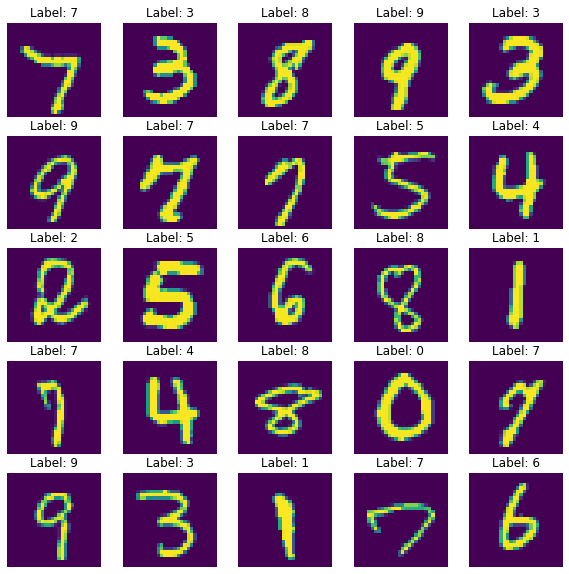

In [14]:
#define data object
mnist = Mnist('/')
train_images, train_labels, test_images, test_labels = mnist.load()
#normalization
train_images = train_images / 255.0
test_images = test_images / 255.0
#reshape dataset 4D train/test features , 1D train/test labels 
train_images = train_images.reshape((60000,28,28,1))
train_labels=train_labels.reshape((60000))
test_images = test_images.reshape((10000,28,28,1))
test_labels=test_labels.reshape((10000))
#show sample of the dataset
mnist.showSample(from_set= "training", startFrom= 0)

In [ ]:
#lenet5
storage=Storage()
#Instantiate an empty model
model_test=model()
# C1 Convolutional Layer
model_test.add(Conv(filters=6,n_prev=1,kernel_size=5, strides=1, padding="same",activation="tanh"))
# S2 Pooling Layer
model_test.add(Pool(pool_size=2,n_prev=6, strides=2, padding="valid", mode = "average"))
# C3 Convolutional Layer
model_test.add(Conv(filters=16,n_prev=6,kernel_size=5, strides=1, padding="valid",activation="tanh"))
# S4 Pooling Layer
model_test.add(Pool(pool_size=2,n_prev=16, strides=2, padding="valid", mode = "average"))
# C5 Convolutional Layer
model_test.add(Conv(filters=120,n_prev=16,kernel_size=5, strides=1, padding="valid",activation="tanh"))
#Flatten the CNN output so that we can connect it with fully connected layers
model_test.add("flatten")
# FC6 Fully Connected Layer
model_test.add(Dense(120,84, activation="tanh"))
#Output Layer with softmax activation
model_test.add(Dense(84,10, activation="softmax"))

#Compile the model
model_test.fit(train_images , train_labels,epochs=1,validation_split=0.1,batchsize=1,plot=1,metrics="all")
storage.save_model(model_test, "buffer1", "/")
model_test.fit(train_images , train_labels,epochs=1,validation_split=0.1,batchsize=1,plot=1,metrics="all")
storage.save_model(model_test, "buffer2", "/")
model_test.fit(train_images , train_labels,epochs=1,validation_split=0.1,batchsize=1,plot=1,metrics="all")
storage.save_model(model_test, "buffer3", "/")
#show model summary
model_test.summary()


In [ ]:
#test the trained model using the testing dataset
model_test.evaluate(test_images , test_labels,metrics="accuracy")

Testing is running----------------->
Loss =102.47156359658153     
0.69


In [ ]:
#define storage object to store the model
storage=Storage()
#save the model
storage.save_model(model_test, "buffer", "/")
modelX=storage.load_model("buffer","/")
#modelX.evaluate(test_images , test_labels,metrics="accuracy")

In [ ]:
#alexnet
#Instantiate an empty model
model_test=model()
# C1 Convolutional Layer
model_test.add(Conv(filters=96,n_prev=1,kernel_size=11, strides=4, padding="valid",activation="relu"))
# S2 Pooling Layer
model_test.add(Pool(pool_size=3,n_prev=96, strides=2, padding="valid", mode = "max"))
# C3 Convolutional Layer
model_test.add(Conv(filters=256,n_prev=96,kernel_size=5, strides=1, padding="same",activation="relu"))
# S4 Pooling Layer
model_test.add(Pool(pool_size=3,n_prev=256, strides=2, padding="valid", mode = "max"))
# C5 Convolutional Layer
model_test.add(Conv(filters=384,n_prev=256,kernel_size=3, strides=1, padding="same",activation="relu"))
# C6 Convolutional Layer
model_test.add(Conv(filters=384,n_prev=384,kernel_size=3, strides=1, padding="same",activation="relu"))
# C7 Convolutional Layer
model_test.add(Conv(filters=256,n_prev=384,kernel_size=3, strides=1, padding="same",activation="relu"))
# S8 Pooling Layer
model_test.add(Pool(pool_size=3,n_prev=256, strides=2, padding="valid", mode = "max"))
#Flatten the CNN output so that we can connect it with fully connected layers
model_test.add("flatten")
# FC8 Fully Connected Layer
model_test.add(Dense(9216,4096, activation="relu"))
# FC9 Fully Connected Layer
model_test.add(Dense(4096,1000, activation="relu"))

#Output Layer with softmax activation
model_test.add(Dense(1000,10, activation="softmax"))

#Compile the model
model_test.fit(train_images , train_labels,epochs=3,validation_split=0.1,batchsize=1,plot=1,metrics="all")
#show model summary
model_test.summary()

In [ ]:
model_test=model()
#learning rate here is 0.01 for dense and conv accuracy about 84%
model_test.add(Conv(filters=6,n_prev=1,kernel_size=5, strides=1, padding="same",activation="tanh"))
model_test.add(Pool(pool_size=2,n_prev=6, strides=2, padding="valid", mode = "max"))
model_test.add("flatten")
model_test.add(Dense(1176,10, activation="softmax"))

train_images = train_images.reshape((60000,28,28,1))


model_test.fit(train_images , train_labels,epochs=3,validation_split=0.1,batchsize=1,plot=0)

# New Section